In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
import scipy.fftpack
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

## Load Dataset
Note: Targets[8] is neutral data

In [2]:
num_targets = 9
targets = [None] * num_targets

for i in range(num_targets):
    targets[i] = pd.read_csv('recordings/first_target_{}.csv'.format(i))
    targets[i]['Unnamed: 0'] = [i % 129 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [3]:
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))
# print(targets[0].columns)
num_samples = len(targets[0].index)

length target 0 = 6400
length target 1 = 6400
length target 2 = 6400
length target 3 = 6400
length target 4 = 6400
length target 5 = 6400
length target 6 = 6400
length target 7 = 6400
length target 8 = 6400


##  Filtering, Averaging, and Plotting Functions

In [4]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(8)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))



# these filtering functions work on each target - only call once
def pca_filter(variance=0.2):
    for i in range(num_targets):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(num_taps=400, band_edges=[0.01, 0.06], fs=None, offset_mode='zero'):
    # filt = signal.firwin(num_taps, [0.01, 0.06], pass_zero=False)
    # filt = signal.firwin(num_taps, [5.0, 35.0], pass_zero=False, fs=128.0)
    if fs is None: 
        filt = signal.firwin(num_taps, band_edges, pass_zero=False)
    else:
        filt = signal.firwin(num_taps, band_edges, pass_zero=False, fs=fs)
    
    for i in range(num_targets):
        for channel in channels:
            if offset_mode == 'average':
                offset = np.average(np.array(targets[i][channel]))
            elif offset_mode == 'minimum':
                offset = np.amin(np.array(targets[i][channel]))
            elif offset_mode == 'same':
                offset = 3800
            elif offset_mode == 'zero':
                offset = 0
            else:
                raise ValueError('choose a valid offset_mode')
            targets[i][channel] = [j - offset for j in targets[i][channel]]
            targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
def alt_fir_filter():
    # source: https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
    sample_rate = 128.0
    nsamples = len(targets[0].index)
    nyq_rate = sample_rate / 2.0
    width = 5.0 / nyq_rate
    ripple_db = 60.0
    N, beta = signal.kaiserord(ripple_db, width)
    cutoff_hz = 8.0
    taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    for i in range(9):
        for channel in channels:
            targets[i][channel] = signal.lfilter(taps, 1.0, np.array(targets[i][channel]))
        
def plot_time_all(xlim=1000):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            targets[i][channel].plot(y=channel, title='Target {} Signal Over Time'.format(i) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        ax.set_xlim(0, xlim)
        
        
def plot_channel(target, channel):
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
    
def plot_fft_all(xlim=0.025):
    N = len(targets[0].index)
    T = 1.0 / 128.0
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            yf = scipy.fftpack.fft(np.array(targets[i][channel])).real
            ax.plot(xf, 2.0 / N * np.abs(yf[:N//2]))
            ax.set_xlim([0, xlim])
        ax.legend(channels)
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
        
def plot_averages():
    # plot all targets all channels on one plot. possibly messy
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, avg_sig in enumerate(averages_all_targets):
        for channel in channels:
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i] if channel=='P7' else "")
    ax.legend()
    ax.set_title('Average Signals for All Targets and All Channels')
    
def plot_target_average(ind):
    # all channels for one target - input is index of targets
    fig, ax = plt.subplots(figsize=(15, 7))
    for j, channel in enumerate(channels):
        averages_all_targets[ind].plot(x='Counter', y=channel, ax=ax, color=my_colors[j], label=channel)
    ax.set_title('Target {} Average Signal for All Channels'.format(ind) if ind != 8 else 'Neutral Target Average Signal for All Channels')
        
def plot_averages_by_channel():
    # 4 plots, each with 8 targets + neutral
    for channel in channels:
        fig, ax = plt.subplots(figsize=(15, 7))
        for i, avg_sig in enumerate(averages_all_targets):
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i])
        ax.legend(loc='upper right')
        ax.set_title('Channel {} Average Signals for All Targets'.format(channel))


def averaging():
    averages = []
    cols = ['Counter', 'O1', 'O2', 'P7', 'P8']
    for target in targets:
        average_for_target = pd.DataFrame(columns = cols)
        for i in range(128):
            o1avg = np.average(target.query('Counter == {}'.format(i))['O1'])
            o2avg = np.average(target.query('Counter == {}'.format(i))['O2'])
            p7avg = np.average(target.query('Counter == {}'.format(i))['P7'])
            p8avg = np.average(target.query('Counter == {}'.format(i))['P8'])
            row = {'Counter' : i, 'O1' : o1avg, 'O2' : o2avg, 'P7' : p7avg, 'P8' : p8avg}
            average_for_target = average_for_target.append(row, ignore_index=True)
        
        averages.append(average_for_target)
    return averages
    

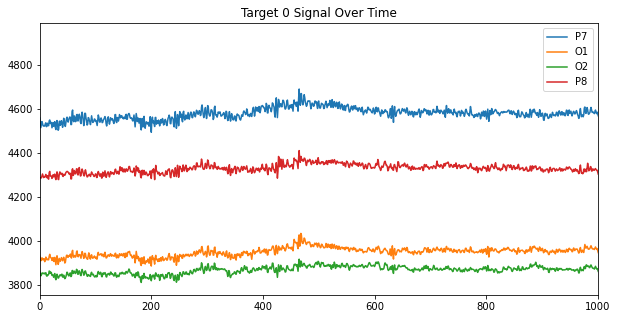

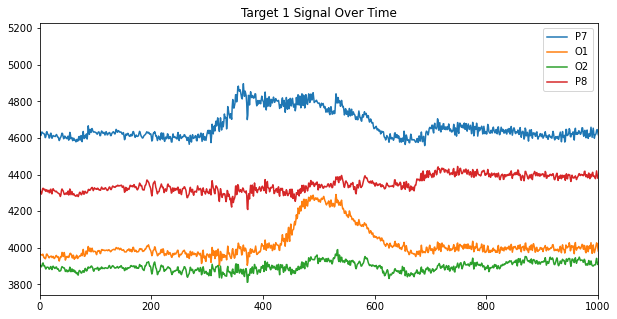

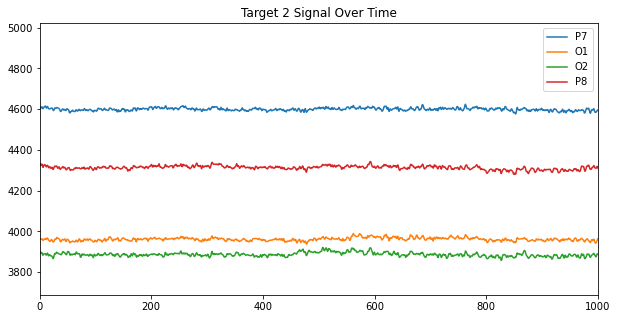

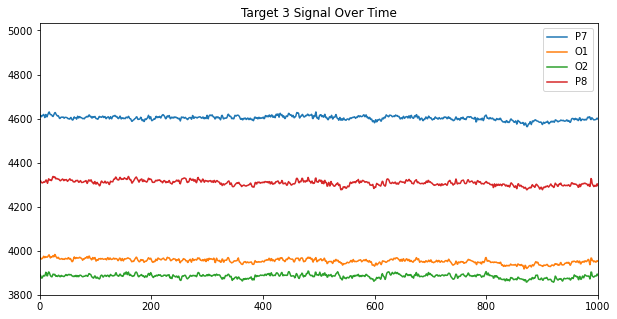

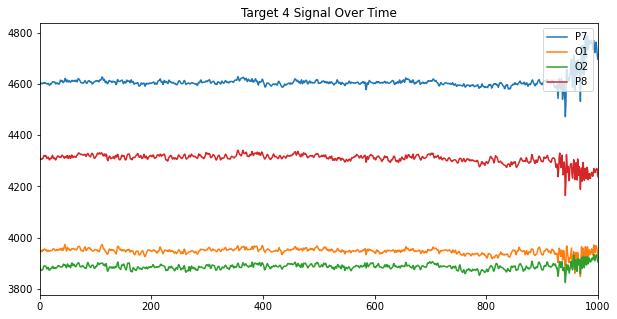

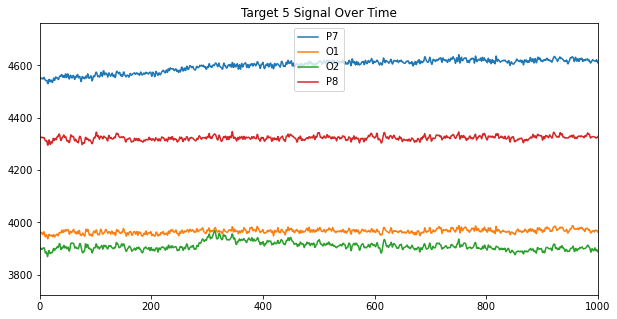

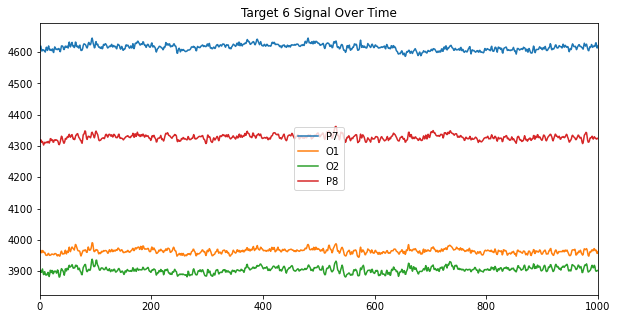

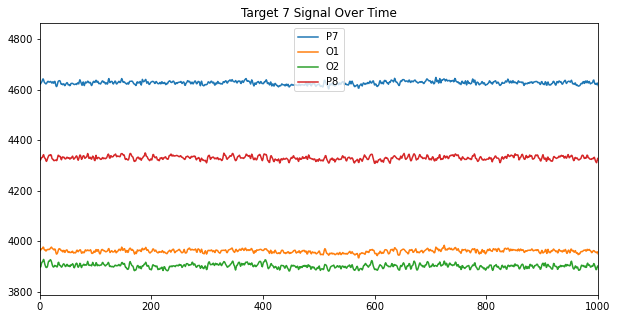

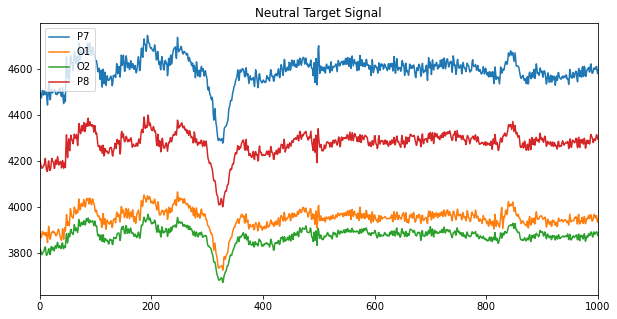

In [5]:
plot_time_all()
# plot_fft_all()

## Apply Filtering

In [6]:
# including comments for testing

# pca_filter(variance=0.5)
fir_filter()
# alt_fir_filter()


# plot_time_all()
# cut_ends()
# plot_channel(targets[0], 'O1')
# plot_fft_all(xlim=7)

In [7]:
cut_ends()
num_samples = len(targets[0].index) # number of samples changes

# plot_time_all(xlim=129)

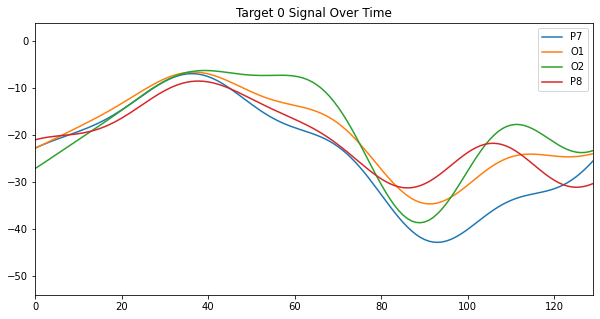

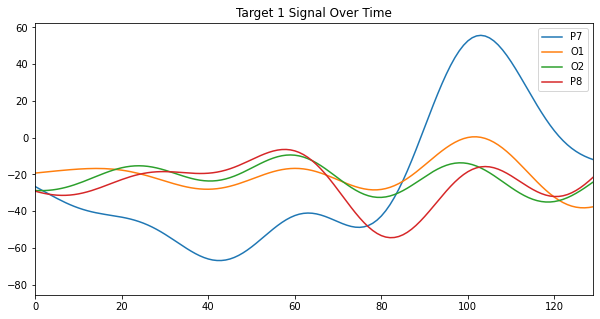

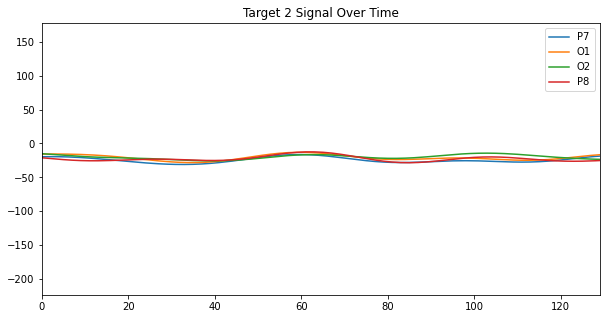

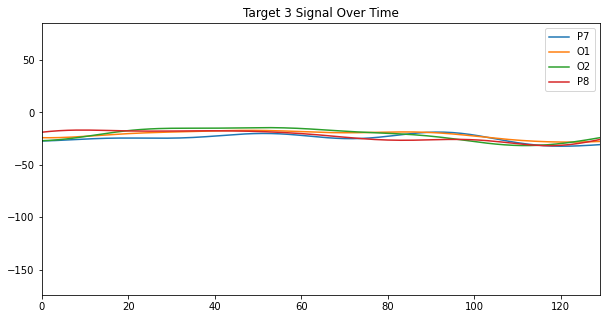

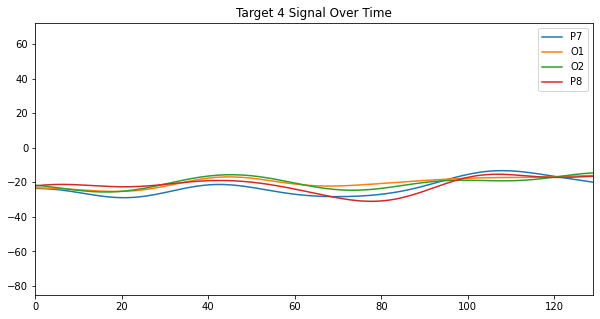

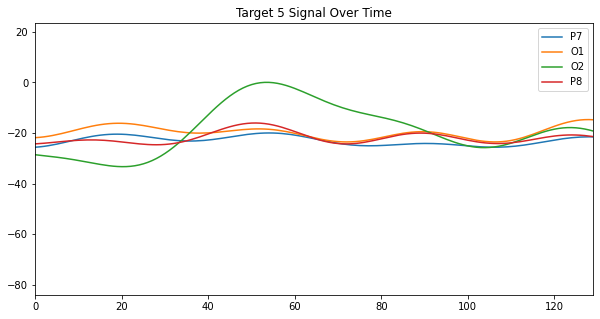

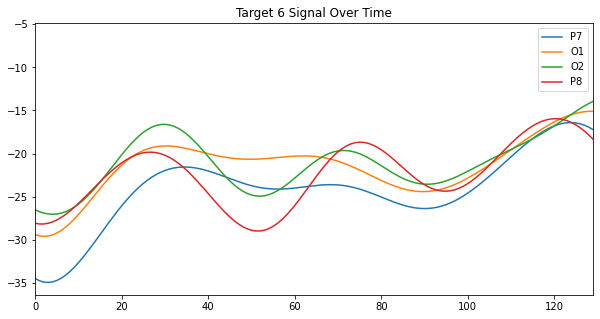

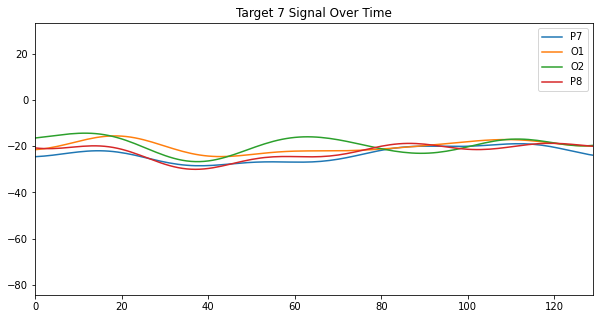

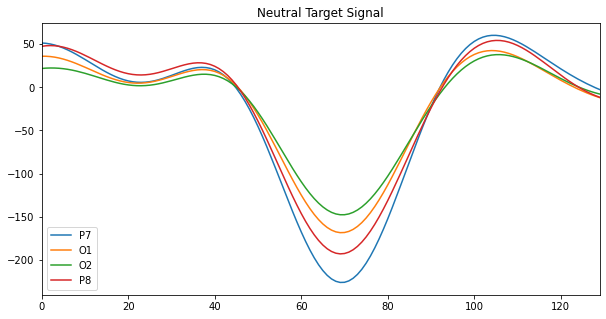

In [8]:
plot_time_all(xlim=129)

## Apply Averaging on Counter Value

In [9]:
# perform averaging for targets
averages_all_targets = averaging()

## Plotting Average Signals

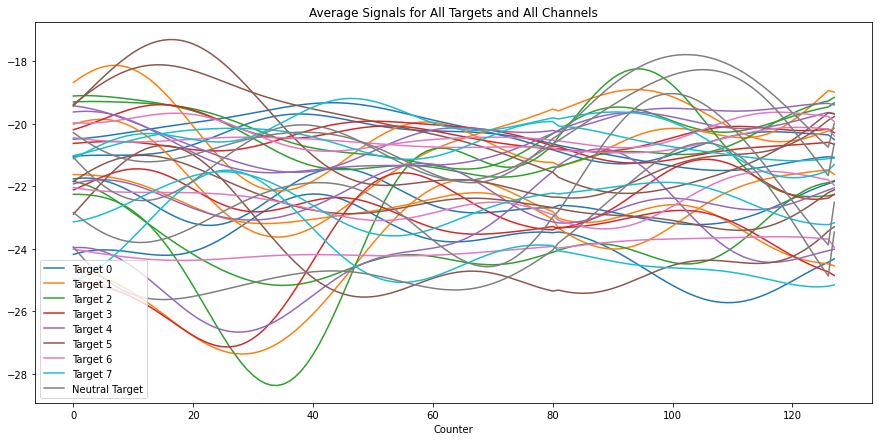

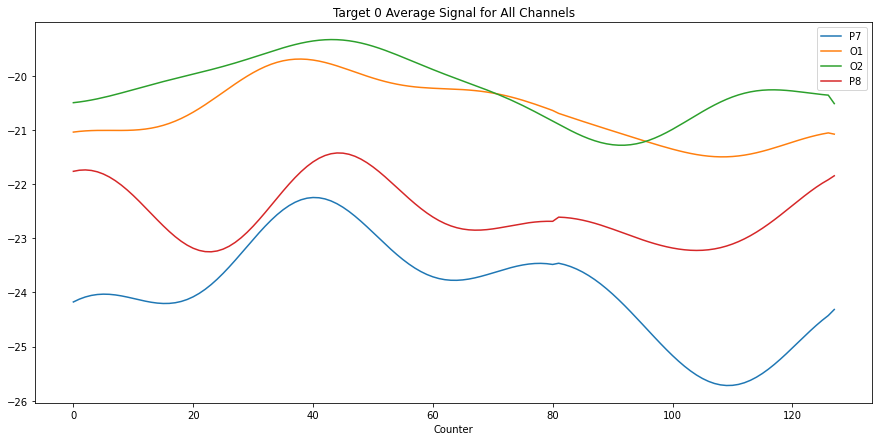

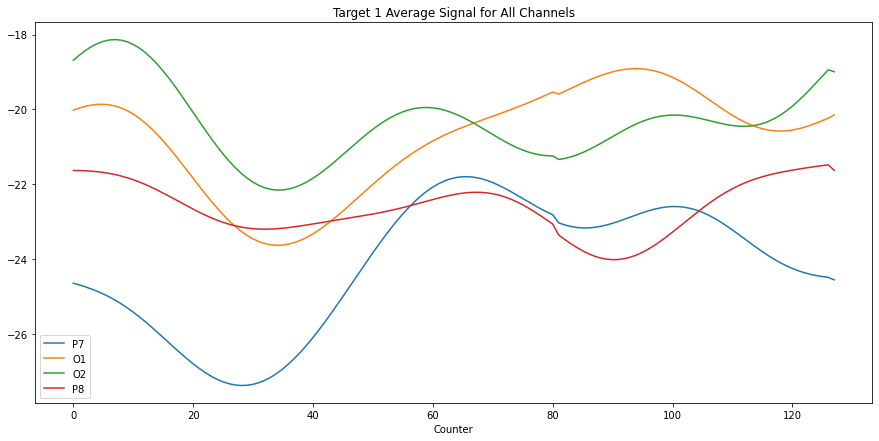

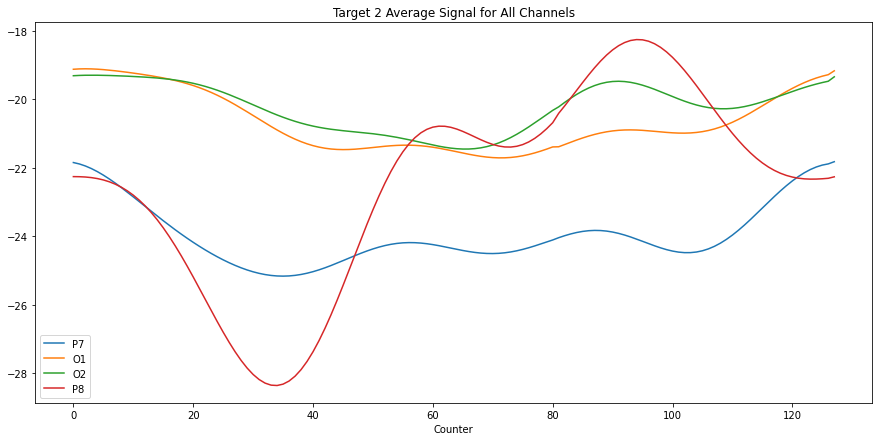

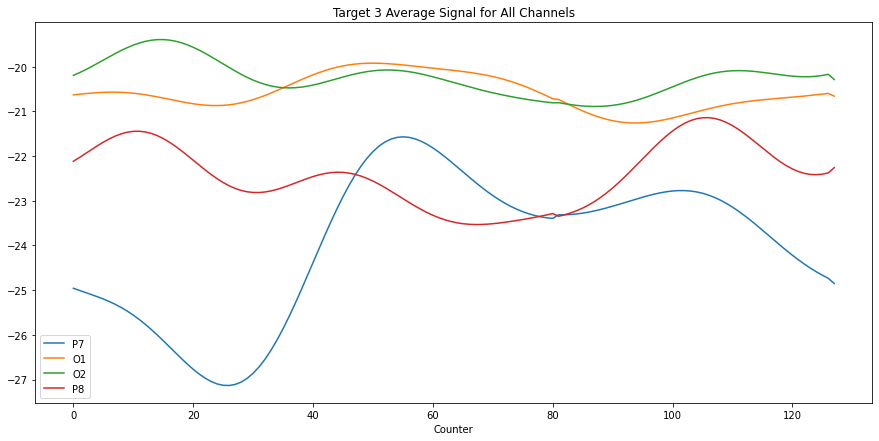

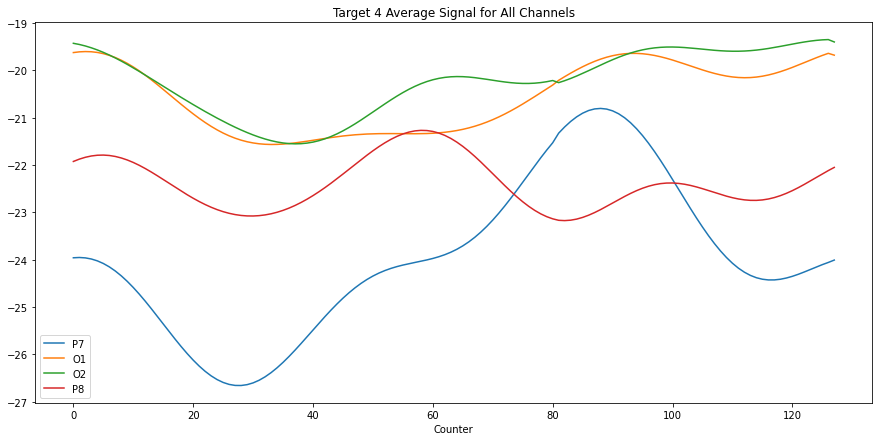

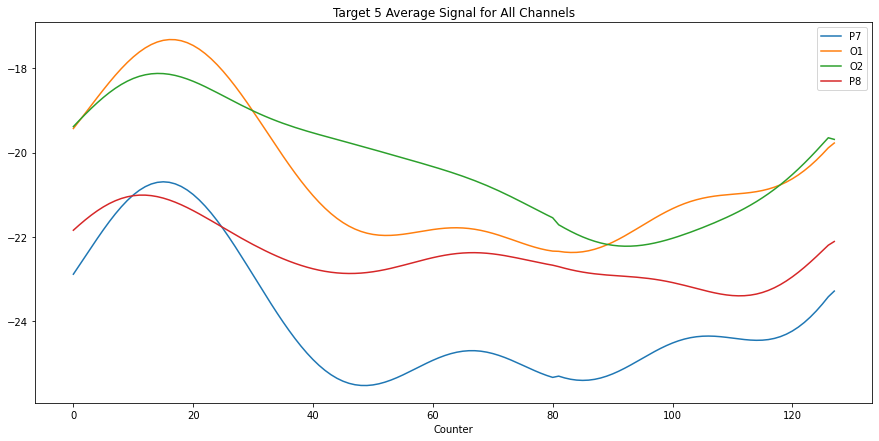

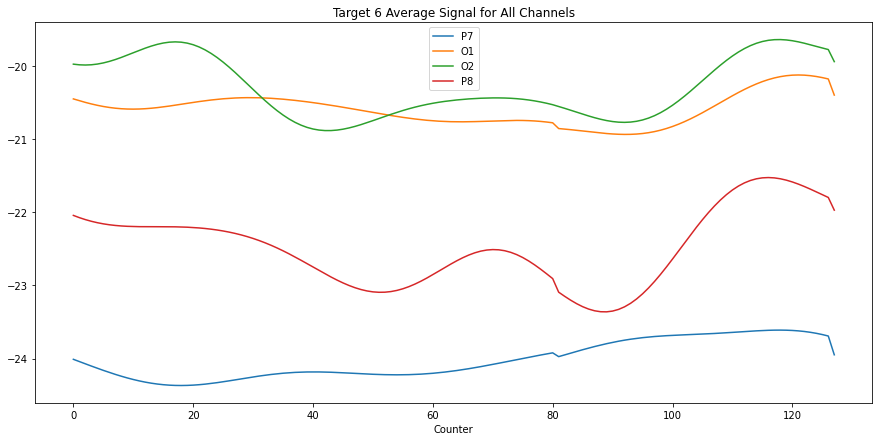

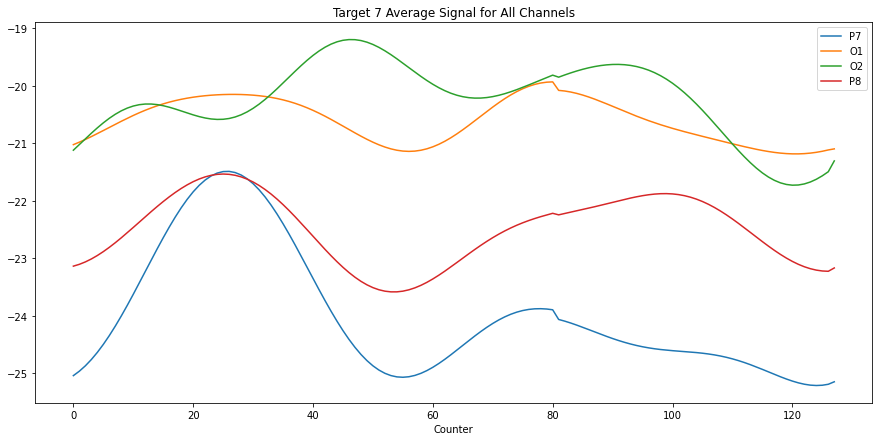

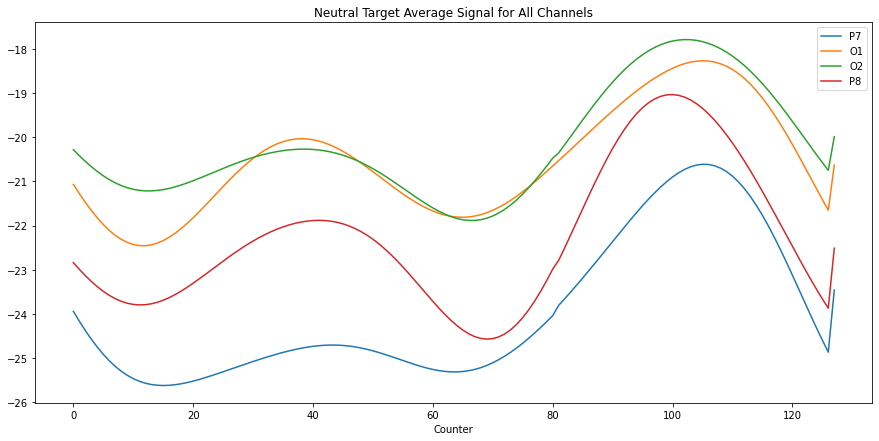

In [10]:
plot_averages()

for i in range(num_targets):
    plot_target_average(i)
    
# plot_averages_by_channel()

## Apply CCA

In [11]:
def ssvep_cca(input_data):

    num_harmonics = 2
    sample_rate = 128.0
    freqs = [30, 20, 15, 12, 10, 8.57, 7.5, 6.67]
    cca_base_matrix = [[] for i in freqs]
    cca_vals = np.zeros([1, len(freqs)], dtype='float')
    # for each target frequency, fill matrix with sine and cosine signals for every harmonic
    for i in range(len(freqs)):
        cca_base_matrix[i] = np.zeros([num_harmonics * 2, num_samples])
        time_count = np.arange(num_samples, dtype='float') / sample_rate
        for harmonic in range(num_harmonics):
            base_const = 2 * np.pi * (harmonic + 1) * freqs[i]
            base_sine = np.sin((base_const * time_count))
            base_cosine = np.cos((base_const * time_count))
            base_pos = harmonic + 1
            sine_pos = (2 * (base_pos - 1) + 1)
            cosine_pos = 2 * base_pos
            cca_base_matrix[i][sine_pos - 1, :] = base_sine
            cca_base_matrix[i][cosine_pos - 1, :] = base_cosine

        y_matrix = cca_base_matrix[i]
        cca = CCA(n_components=num_harmonics)
        
        # cca.fit(np.transpose(input_data), np.transpose(y_matrix))
        # x, y = cca.transform(input_data, y_matrix)
        # cca_vals[0, i] = cca.score(input_data, y_matrix, y)
        
        print('shape input_data = {}, y_matrix = {}'.format(input_data.shape, y_matrix.shape))
        cca.fit(np.transpose(input_data), np.transpose(y_matrix))
        x, y = cca.transform(input_data, y_matrix)
        print('shape x = {}, y = {}'.format(x.shape, y.shape))
        cca_vals[0, i] = cca.score(input_data, y_matrix, y)
        
    return cca_vals

In [12]:
# try comparing with averages
num_seconds = int(len(targets[0]) / 128)
one_period = np.array([np.array(averages_all_targets[i][channels]) for i in range(8)]) # 8 x 128 x 4
# print(one_period.shape)
ref_signals_3d = np.repeat(one_period, num_seconds, axis=1) # 8 x 5888 x 4
# print(ref_signals.shape)
input_data_3d = np.array([np.array(targets[i][channels]) for i in range(8)]) # 8 x 5888 x 4
# print(input_data.shape)

In [13]:
ref_signals_2d = np.hstack([ref_signals_3d[i] for i in range(8)]) # 5888 x 32
input_data_2d = np.hstack([input_data_3d[i] for i in range(8)]) # 5888 x 32
# print(ref_signals_2d.shape)
# print(input_data_2d.shape)

In [14]:
# trial 1 - get score but not right - close to 1 always?

scores = [[None] * 8] * 8
for i in range(8):
    for j in range(8):
        cca = CCA(n_components = 1)
        cca.fit(input_data_3d[i], ref_signals_3d[j])
        c_x, c_y = cca.transform(input_data_3d[i], ref_signals_3d[j])
        scores[i][j] = cca.score(input_data_3d[i], ref_signals_3d[j], c_y)
        # print('input {} ref {} score = {}'.format(i, j, scores[i][j]))


In [15]:
# print("\n".join(['input {} ref {} score = {}'.format(i, j, scores[i][j]) for j in range(8) for i in range(8)]))

In [16]:
# trial 2 - list of cca objects 

cca_list = [None] * 8
c_x = [None] * 8
c_y = [None] * 8
scores = [[None] * 8] * 8

for i in range(8):
    # i refers to current input
    for j in range(8):
        # j refers to target to compare against
        cca_list[i] = CCA(n_components = 1)
        cca_list[i].fit(input_data_3d[i], ref_signals_3d[j])
        c_x[i], c_y[i] = cca_list[i].transform(input_data_3d[i], ref_signals_3d[j])
        scores[i][j] = cca_list[i].score(input_data_3d[i], ref_signals_3d[j], c_y[i])


In [17]:
# print("\n".join(['input {} ref {} score = {}'.format(i, j, scores[i][j]) for j in range(8) for i in range(8)]))

In [18]:
# trial 3 - c_x, c_y 2d

cca_list = [None] * 8
c_x = [[None] * 8] * 8
c_y = [[None] * 8] * 8
scores = [[None] * 8] * 8

for i in range(8):
    # i refers to current input
    for j in range(8):
        # j refers to target to compare against
        cca_list[i] = CCA(n_components = 1)
        cca_list[i].fit(input_data_3d[i], ref_signals_3d[j])
        c_x[i][j], c_y[i][j] = cca_list[i].transform(input_data_3d[i], ref_signals_3d[j])
        scores[i][j] = cca_list[i].score(input_data_3d[i], ref_signals_3d[j], c_y[i][j])


In [19]:
# trial 4 - try inspired CCA
# source: https://github.com/aaravindravi/PythonBox_OpenViBE_SSVEP_CCA/blob/master/4ClassCCA.py

# for each chunk....
# get reference signal for each freq
# n_components = 1
# concatenate all templates into one matrix
# findCorr(1, buffer, freq matrix)
# max_result = max(result)
# predictedClass = np.argmax(result)+1
# print the predicted class

freqs = [30, 20, 15, 12, 10, 8.57, 7.5, 6.67]

def getReferenceSignals(target_freq):
    # generate sinusoidal reference templates for CCA for first and second harmonics
    reference_signals = []
    sampling_rate = 128.0
    samples = 5888
    t = np.arange(0, (samples/sampling_rate), step=1.0/sampling_rate)
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)
    print('shape reference_signals for freq {}: {}'.format(target_freq, reference_signals.shape))
    return reference_signals

    

def findCorr(input_data, freq):
    cca = CCA(n_components=1)
    corr = 0
    result = np.zeros((freq.shape)[0])
    for freqIdx in range(0, (freq.shape)[0]):
        cca.fit(input_data, np.squeeze(freq[freqIdx,:,:]).T)
        a, b = cca.transform(input_data, np.squeeze(freq[freqIdx,:,:]).T)
        corr = np.corrcoef(a[:,0], b[:,0])[0, 1]
        print('freq = {}\tcorr = {}'.format(freqs[freqIdx], corr))
        result[freqIdx] = corr
    
    return result




refs = []
for freq in freqs:
    refs.append(getReferenceSignals(freq))
refs = np.array(refs)

for i in range(8):
    print('find corrs for target {}'.format(i))
    result = findCorr(input_data_3d[i], refs)
    predicted = np.argmax(result)
    print('\npredict target {}\n'.format(predicted))
    





shape reference_signals for freq 30: (4, 5888)
shape reference_signals for freq 20: (4, 5888)
shape reference_signals for freq 15: (4, 5888)
shape reference_signals for freq 12: (4, 5888)
shape reference_signals for freq 10: (4, 5888)
shape reference_signals for freq 8.57: (4, 5888)
shape reference_signals for freq 7.5: (4, 5888)
shape reference_signals for freq 6.67: (4, 5888)
find corrs for target 0
freq = 30	corr = 0.0005446742305805237
freq = 20	corr = 0.0007419025343731198
freq = 15	corr = 0.0009638860679217948
freq = 12	corr = 0.0011966781962407034
freq = 10	corr = 0.001433772335690275
freq = 8.57	corr = 0.0012649096931814266
freq = 7.5	corr = 0.0019390743177040341
freq = 6.67	corr = 0.0020253486485853323

predict target 7

find corrs for target 1
freq = 30	corr = 0.0003958556668238859
freq = 20	corr = 0.000540614232229412
freq = 15	corr = 0.000705063843744157
freq = 12	corr = 0.0008783420389701683
freq = 10	corr = 0.001058936325741086
freq = 8.57	corr = 0.0009364687317286295
fre

In [20]:
# data = np.array(targets[0]['O1']).reshape(-1, 1)
# print(data.shape)
# scores = ssvep_cca(data)

In [21]:
row = 0
print(targets[0][channels][row:row+128])
row += 128
print(targets[0][channels][row:row+128])

            P7         O1         O2         P8
0   -22.800256 -22.852399 -27.152576 -21.054303
1   -22.395337 -22.416187 -26.562394 -20.826205
2   -22.007774 -21.971430 -25.956697 -20.638697
3   -21.636936 -21.520996 -25.340978 -20.485907
4   -21.281654 -21.067425 -24.719906 -20.361299
..         ...        ...        ...        ...
123 -30.204903 -24.692296 -23.125548 -30.912635
124 -29.623885 -24.683836 -23.457665 -31.099391
125 -28.957124 -24.633482 -23.680288 -31.169685
126 -28.205198 -24.538545 -23.783318 -31.124275
127 -27.372026 -24.398374 -23.760585 -30.967739

[128 rows x 4 columns]
            P7         O1         O2         P8
128 -26.465721 -24.214973 -23.610394 -30.708941
129 -25.497686 -23.992267 -23.335134 -30.360031
130 -24.481244 -23.735328 -22.940559 -29.935305
131 -23.432442 -23.450955 -22.435928 -29.451374
132 -22.370309 -23.147665 -21.834006 -28.927132
..         ...        ...        ...        ...
251 -26.213273 -20.834478 -13.332742 -22.967342
252 -25.686581 -